In [1]:
from google.colab import drive 
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
%cd drive/MyDrive/Dataset/
%ls

/content/drive/MyDrive/Dataset
AOD/  AOD.pth  challenging-60/  deep_learning.ipynb  raw-890/  reference-890/


In [3]:
!pip install torchsummary

import zipfile
import os
import math 
import torch
import gc
import torchvision
import argparse
import glob
import time

import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import PIL.Image as Image

from torchvision.datasets.folder import make_dataset as make_dataset_original
from torchvision.datasets.folder import default_loader
from torchvision.datasets.vision import VisionDataset
from torchvision.transforms import ToTensor
from skimage.io import imsave
from torchvision import models
from torchsummary import summary
from tqdm import tqdm

%matplotlib inline

In [4]:
# Create custom dataset with original and target images
# Solution from https://stackoverflow.com/questions/59467781/pytorch-dataloader-for-image-gt-dataset

def make_dataset(root: str) -> list:
    """
    Reads a directory with data.
    Returns a dataset as a list of tuples of paired image paths: (rgb_path, gt_path)
    """
    dataset = []

    # Our dir names
    orig_dir = 'raw-890'
    tar_dir  = 'reference-890'   

    # Get all the filenames from RGB folder
    orig_fnames = sorted(os.listdir(os.path.join(root, orig_dir)))

    # Compare file names from GT folder to file names from RGB:
    for tar_fname in sorted(os.listdir(os.path.join(root, tar_dir))):

            if tar_fname in orig_fnames:
                # if we have a match - create pair of full path to the corresponding images
                orig_path = os.path.join(root, orig_dir, tar_fname)
                tar_path = os.path.join(root, tar_dir, tar_fname)

                item = (orig_path, tar_path)
                # append to the list dataset
                dataset.append(item)
            else:
                continue

    return dataset


class CustomVisionDataset(VisionDataset):

    def __init__(self, root, loader=default_loader, rgb_transform=None, gt_transform=None):
        
        super().__init__(root, transform=transform, target_transform=transform)

        # Prepare dataset
        samples = make_dataset(self.root)

        self.loader = loader
        self.samples = samples
        # list of RGB images
        self.rgb_samples = [s[1] for s in samples]
        # list of GT images
        self.gt_samples = [s[1] for s in samples]

    def __getitem__(self, index):
        """
        Returns a data sample from our dataset.
        """
        # getting our paths to images
        rgb_path, gt_path = self.samples[index]

        # import each image using loader (by default it's PIL)
        rgb_sample = self.loader(rgb_path)
        gt_sample = self.loader(gt_path)

        # here goes tranforms if needed
        # maybe we need different tranforms for each type of image
        if self.transform is not None:
            rgb_sample = self.transform(rgb_sample)
        
        if self.target_transform is not None:
            gt_sample = self.target_transform(gt_sample)      

        # now we return the right imported pair of images (tensors)
        return rgb_sample, gt_sample

    def __len__(self):
        return len(self.samples)

In [5]:
class AODNet(nn.Module):
    def __init__(self):
        super(AODNet, self).__init__()
        """
        AOD-Net definition. Initialization of layers.
        
        Paper: https://openaccess.thecvf.com/content_ICCV_2017/papers/Li_AOD-Net_All-In-One_Dehazing_ICCV_2017_paper.pdf
        """
        
        # Convolutional layers
        self.cv1  = nn.Conv2d(in_channels=3 , out_channels=3, kernel_size=1, stride=1, padding=0)
        self.cv2  = nn.Conv2d(in_channels=3 , out_channels=3, kernel_size=3, stride=1, padding=1)
        self.cv3  = nn.Conv2d(in_channels=6 , out_channels=3, kernel_size=5, stride=1, padding=2)
        self.cv4  = nn.Conv2d(in_channels=6 , out_channels=3, kernel_size=7, stride=1, padding=3)
        self.cv5  = nn.Conv2d(in_channels=12, out_channels=3, kernel_size=3, stride=1, padding=1)
        
        # ReLU and bias
        self.relu = nn.ReLU()
        self.b    = 1

    def forward(self, x):
        """
        Pass input through layers. Alternation between conv + relu and cat layers.
        """
        out1 = self.cv1(x)
        out1 = self.relu(out1)
        
        out2 = self.cv2(out1)
        out2 = self.relu(out2)
        
        cat1 = torch.cat((out1, out2), 1)
        
        out3 = self.cv3(cat1)
        out3 = self.relu(out3)
        
        cat2 = torch.cat((out2, out3), 1)
        
        out4 = self.cv4(cat2)
        out4 = self.relu(out4)
        
        cat3 = torch.cat((out1, out2, out3, out4), 1)
        
        k = self.cv5(cat3)
        k = self.relu(k)

        output = k * x - k + self.b
        
        return self.relu(output)

AOD_model = AODNet().cuda()

summary(AOD_model, (3, 899, 899))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 3, 899, 899]              12
              ReLU-2          [-1, 3, 899, 899]               0
            Conv2d-3          [-1, 3, 899, 899]              84
              ReLU-4          [-1, 3, 899, 899]               0
            Conv2d-5          [-1, 3, 899, 899]             453
              ReLU-6          [-1, 3, 899, 899]               0
            Conv2d-7          [-1, 3, 899, 899]             885
              ReLU-8          [-1, 3, 899, 899]               0
            Conv2d-9          [-1, 3, 899, 899]             327
             ReLU-10          [-1, 3, 899, 899]               0
             ReLU-11          [-1, 3, 899, 899]               0
Total params: 1,761
Trainable params: 1,761
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 9.25
Forward/back

In [6]:
#os.makedirs('AOD')
#os.makedirs('AOD/Results')

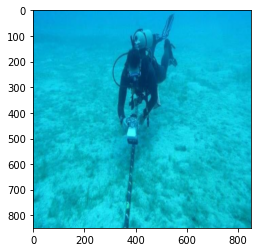

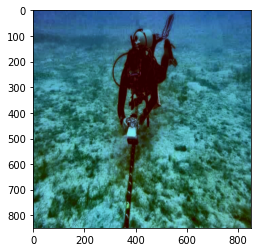

In [7]:
# Convert to tensors
transform = transforms.Compose([
    transforms.Resize((849, 849)),
    transforms.ToTensor(),
])

batch_size = 32
shuffle = True
root = ''

dataset = CustomVisionDataset('', rgb_transform=transform, gt_transform=transform)
train_set, val_set = torch.utils.data.random_split(dataset, [800, 90])

trainloader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=shuffle, num_workers=1)
valloader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=shuffle, num_workers=1)

plt.imshow(train_set[16][0].permute(1, 2, 0))
plt.show()

plt.imshow(train_set[16][1].permute(1, 2, 0))
plt.show()

In [8]:
# Training cell
print("Training AOD model!")

aod_training_loss   = []
aod_validation_loss = []

optimizer = torch.optim.Adam(params=AOD_model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1)

criterion = nn.MSELoss()

best_loss = math.inf

for epoch in range(40):
    full_loss   = 0
    
    AOD_model.train()

    for index, (data, target) in enumerate(trainloader):

        # Move to GPU
        orig_data, ref_data = data.cuda(), target.cuda()

        # Rashape ref data for loss
        ref_data = ref_data.reshape(ref_data.size(0), -1)

        optimizer.zero_grad()

        # Reconstruction
        output = AOD_model(orig_data)
        output = output.reshape(output.size(0), -1)

        # Compute loss
        loss = criterion(output, ref_data)
        #loss = loss_function(output, ref_data, 'MSE')
        full_loss = full_loss + loss.item()

        # Backprop
        loss.backward()
        optimizer.step()
        
        # print('--> Train Epoch: {} [{}/{} ({:.0f}%)]\tBatch Loss: {:.6f}'.format(
        #    epoch, index * len(orig_data), len(trainloader.dataset),
        #    100. * index / len(trainloader), loss.item()))
        
    AOD_model.eval()   # Set model to evaluate mode

    validation_loss = 0

    for data, target in valloader:
        
        # Move to GPU
        orig_data, ref_data = data.cuda(), target.cuda()
        
        # Rashape ref data for loss
        ref_data = ref_data.reshape(ref_data.size(0), -1)
        
        # Evaluate
        output = AOD_model(orig_data)
        output = output.reshape(output.size(0), -1)
        
        # Compute loss
        loss = criterion(output, ref_data)
        validation_loss = validation_loss + loss.item()
        
    validation_loss /= len(valloader.dataset)
    full_loss /= len(trainloader.dataset)
            
    scheduler.step()
    
    if (validation_loss < best_loss):
        best_loss = validation_loss
        
        print("--> Saving model!")
        model_file = 'AOD/AOD.pth'
        torch.save(AOD_model.state_dict(), model_file)

    aod_training_loss.append(full_loss)
    aod_validation_loss.append(validation_loss)

    print("Train Epoch {}: average training loss {}, average validation loss {}".format(epoch, full_loss, validation_loss))

Training AOD model!
--> Saving model!
Train Epoch 0: average training loss 0.009197325985878706, average validation loss 0.004682342873679267
--> Saving model!
Train Epoch 1: average training loss 0.0018230430874973536, average validation loss 0.0007764868852165011
--> Saving model!
Train Epoch 2: average training loss 0.0007808636943809688, average validation loss 0.0006863917741510603
Train Epoch 3: average training loss 0.0007251717010512949, average validation loss 0.0007122314431601101
Train Epoch 4: average training loss 0.0007251327577978373, average validation loss 0.0007030426835020384
Train Epoch 5: average training loss 0.0007184335612691939, average validation loss 0.0006971870652503437
Train Epoch 6: average training loss 0.0007157265418209135, average validation loss 0.000688632619049814
--> Saving model!
Train Epoch 7: average training loss 0.000698858016403392, average validation loss 0.0006687781463066737
--> Saving model!
Train Epoch 8: average training loss 0.0006656

Original images.


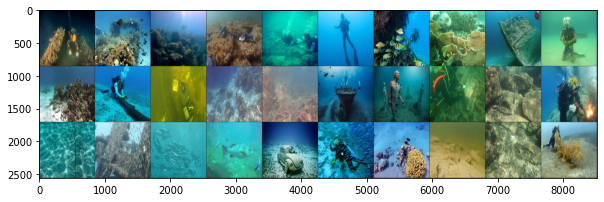

Ground truth images.


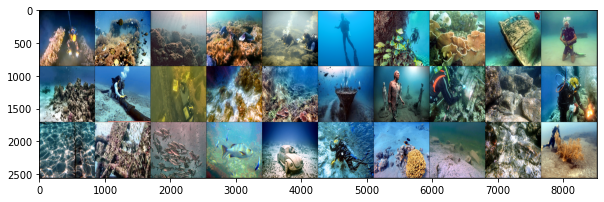

Model outputs.


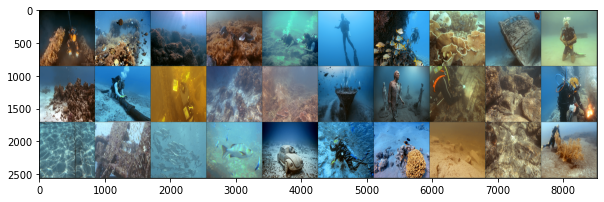

In [12]:
# test_dir = 'challenging-60-super'

# test_dataset = datasets.ImageFolder('challenging-60-super/', transform=transform)
# test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False) 

AOD_model = AODNet()
state_dict = torch.load('AOD/AOD.pth')
AOD_model.load_state_dict(state_dict)
AOD_model.eval()

AOD_model.cuda()

def imshow(img):
    # unnormalize
    img = img.clamp(0, 1)
    npimg = img.numpy()
    fig = plt.figure(figsize=(10,10))
    ax  = fig.add_subplot(111)
    ax.imshow(np.transpose(npimg, (1, 2, 0)))
    #ax.set_title('CNN VAE (80 Epochs)')
    plt.show()
    #fig.savefig('example.png', dpi = 300)
    
# get some random training images
dataiter = iter(valloader)
images, labels = dataiter.next()

print("Original images.")
imshow(torchvision.utils.make_grid(images[:30], 10, 3))

print("Ground truth images.")
imshow(torchvision.utils.make_grid(labels[:30], 10, 3))

print("Model outputs.")
with torch.no_grad():
    images      = images.cuda()
    outs        = AOD_model(images)
    outs        = outs.cpu()
    outs        = torch.reshape(outs, images.shape)
    imshow(torchvision.utils.make_grid(outs[:30], 10, 3))

In [11]:
test_dir = 'challenging-60'

testtransform = transforms.Compose([
    transforms.ToTensor(),
])

AOD_model = AODNet()
state_dict = torch.load('AOD/AOD.pth')
AOD_model.load_state_dict(state_dict)
AOD_model.eval()

AOD_model.cuda()

def pil_loader(path):
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, 'rb') as f:
        with Image.open(f) as img:
            return img.convert('RGB')

for f in tqdm(os.listdir(test_dir)):
    if 'png' in f:
        data = testtransform(pil_loader(test_dir + '/' + f))
        data = data.view(1, data.size(0), data.size(1), data.size(2))
        data = data.cuda()

        output = AOD_model(data)
        output = output.squeeze(0)
        output = output.permute(1, 2, 0)
        
        im = output.cpu().detach().numpy()
        
        #plt.imshow(pil_loader(test_dir + '/' + f))
        #plt.show() 

        imsave('AOD/Results/' + f, im)

        #plt.imshow(im)
        #plt.show()  

100%|██████████| 60/60 [01:39<00:00,  1.66s/it]


In [7]:
class Conv_Block(nn.Module):
    def __init__(self, in_size, out_size):
        super(Conv_Block, self).__init__()
        """
        Conv block from ReExpose-net definition.
        
        Paper: https://ieeexplore.ieee.org/document/8803546 
        """

        # Convolutional layers
        self.cv1  = nn.Conv2d(in_channels=in_size , out_channels=out_size//4, kernel_size=3, dilation=1, padding=1)
        self.cv2  = nn.Conv2d(in_channels=in_size , out_channels=out_size//4, kernel_size=3, dilation=2, padding=2)
        self.cv3  = nn.Conv2d(in_channels=in_size , out_channels=out_size//4, kernel_size=3, dilation=4, padding=4)
        self.cv4  = nn.Conv2d(in_channels=in_size , out_channels=out_size//4, kernel_size=3, dilation=8, padding=8)
        self.cv5  = nn.Conv2d(in_channels=out_size , out_channels=out_size, kernel_size=1, dilation=1)

    def forward(self, x):
        """
        Pass input through layers. Conv + elu and cat layers.
        """
        out1 = F.elu(self.cv1(x))        
        out2 = F.elu(self.cv2(x))
        out3 = F.elu(self.cv3(x))
        out4 = F.elu(self.cv4(x))
        
        cat  = torch.cat((out1, out2, out3, out4), 1)

        out  = F.elu(self.cv5(cat))
        
        return out


class RE_Expose_Net(nn.Module):
    def __init__(self):
        super(RE_Expose_Net, self).__init__()
        """
        ReExpose-net definition. Initialization of layers.
        
        Paper: https://github.com/steffensbola/u_can_32_image_exposure/blob/master/manuscript_icip.pdf
        """
        # Define conv blocks
        self.bloc1 = Conv_Block(3, 32)
        self.bloc2 = Conv_Block(32, 64)
        self.bloc3 = Conv_Block(64, 128)
        self.bloc4 = Conv_Block(128, 64)
        self.bloc5 = Conv_Block(96, 32)
        
        # Convolutional layers
        self.cv1_a   = nn.Conv2d(in_channels=128 , out_channels=64, kernel_size=3, dilation=1, padding=1)
        self.cv1_b   = nn.Conv2d(in_channels=64 , out_channels=32, kernel_size=3, dilation=1, padding=1)
        self.cv2_a   = nn.Conv2d(in_channels=32 , out_channels=32, kernel_size=3, stride=2, dilation=1)
        self.cv2_b   = nn.Conv2d(in_channels=64 , out_channels=64, kernel_size=3, stride=2, dilation=1)
        
        self.cv1   = nn.Conv2d(in_channels=32 , out_channels=3, kernel_size=3, dilation=1, padding=1)
        self.cv2   = nn.Conv2d(in_channels=32 , out_channels=3, kernel_size=3, dilation=1, padding=1)
        self.cv3   = nn.Conv2d(in_channels=32 , out_channels=32, kernel_size=1, dilation=1)
        self.cv4   = nn.Conv2d(in_channels=32 , out_channels=32, kernel_size=3, dilation=1, padding=1)

        # Other
        self.BN = torch.nn.BatchNorm2d(64)

    def forward(self, x):
        """
        Pass input through layers. Alternation between conv + relu and cat layers.
        """
        # Main branch
        main = self.bloc1(x)

        # First Branch
        bra1 = F.elu(self.cv2_a(main))

        # Second branch
        bra2 = self.bloc2(bra1)
        bra2 = F.elu(self.cv2_b(bra2))

        # Third branch
        bra3 = self.bloc3(bra2)
        bra3 = F.elu(self.cv1_a(bra3))

        # Second branch
        bra2 = torch.cat((bra2, bra3), 1)
        bra2 = self.bloc4(bra2)
        bra2 = F.interpolate(bra2, size=(bra1.shape[2], bra1.shape[3]), mode='nearest')
        
        # First branch
        bra1 = torch.cat((bra1, bra2), 1)
        bra1 = self.bloc5(bra1)
        bra1 = F.interpolate(bra1, size=(x.shape[2], x.shape[3]), mode='nearest')

        # Main branch
        main = F.elu(self.cv4(main))
        main = F.elu(self.cv4(main))
        main = torch.cat((main, bra1), 1)
        main = self.BN(main)
        main = F.elu(self.cv1_b(main))
        main = F.elu(self.cv3(main))
        main = F.relu(self.cv1(main))
        
        return main

RE_Expose = RE_Expose_Net().cuda()

summary(RE_Expose, (3, 899, 899))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 899, 899]             224
            Conv2d-2          [-1, 8, 899, 899]             224
            Conv2d-3          [-1, 8, 899, 899]             224
            Conv2d-4          [-1, 8, 899, 899]             224
            Conv2d-5         [-1, 32, 899, 899]           1,056
        Conv_Block-6         [-1, 32, 899, 899]               0
            Conv2d-7         [-1, 32, 449, 449]           9,248
            Conv2d-8         [-1, 16, 449, 449]           4,624
            Conv2d-9         [-1, 16, 449, 449]           4,624
           Conv2d-10         [-1, 16, 449, 449]           4,624
           Conv2d-11         [-1, 16, 449, 449]           4,624
           Conv2d-12         [-1, 64, 449, 449]           4,160
       Conv_Block-13         [-1, 64, 449, 449]               0
           Conv2d-14         [-1, 64, 2

In [8]:
#os.makedirs('ReExpose')
#os.makedirs('ReExpose/Results')

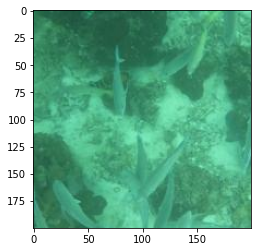

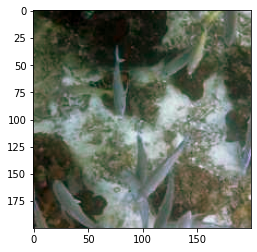

In [9]:
# Convert to tensors
transform = transforms.Compose([
    transforms.CenterCrop((200, 200)),
    transforms.ToTensor(),
])

batch_size = 80
shuffle = True
root = ''

dataset = CustomVisionDataset('', rgb_transform=transform, gt_transform=transform)
train_set, val_set = torch.utils.data.random_split(dataset, [800, 90])

trainloader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=shuffle, num_workers=1)
valloader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=shuffle, num_workers=1)

plt.imshow(train_set[16][0].permute(1, 2, 0))
plt.show()

plt.imshow(train_set[16][1].permute(1, 2, 0))
plt.show()

In [10]:
# Training cell
print("Training RE Expose model!")

re_training_loss   = []
re_validation_loss = []

optimizer = torch.optim.Adam(params=RE_Expose.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1)

criterion = nn.MSELoss()

best_loss = math.inf

for epoch in range(40):
    full_loss   = 0
    
    RE_Expose.train()

    for index, (data, target) in enumerate(trainloader):

        # Move to GPU
        orig_data, ref_data = data.cuda(), target.cuda()

        # Rashape ref data for loss
        ref_data = ref_data.reshape(ref_data.size(0), -1)

        optimizer.zero_grad()

        # Reconstruction
        output = RE_Expose(orig_data)
        output = output.reshape(output.size(0), -1)

        # Compute loss
        loss = criterion(output, ref_data)
        #loss = loss_function(output, ref_data, 'MSE')
        full_loss = full_loss + loss.item()

        # Backprop
        loss.backward()
        optimizer.step()
        
        # print('--> Train Epoch: {} [{}/{} ({:.0f}%)]\tBatch Loss: {:.6f}'.format(
        #    epoch, index * len(orig_data), len(trainloader.dataset),
        #    100. * index / len(trainloader), loss.item()))
        
    RE_Expose.eval()   # Set model to evaluate mode

    validation_loss = 0

    for data, target in valloader:
        
        # Move to GPU
        orig_data, ref_data = data.cuda(), target.cuda()
        
        # Rashape ref data for loss
        ref_data = ref_data.reshape(ref_data.size(0), -1)
        
        # Evaluate
        output = RE_Expose(orig_data)
        output = output.reshape(output.size(0), -1)
        
        # Compute loss
        loss = criterion(output, ref_data)
        validation_loss = validation_loss + loss.item()
        
    validation_loss /= len(valloader.dataset)
    full_loss /= len(trainloader.dataset)
            
    scheduler.step()
    
    if (validation_loss < best_loss):
        best_loss = validation_loss
        
        print("--> Saving model!")
        model_file = 'ReExpose/ReExpose.pth'
        torch.save(RE_Expose.state_dict(), model_file)

    re_training_loss.append(full_loss)
    re_validation_loss.append(validation_loss)

    print("Train Epoch {}: average training loss {}, average validation loss {}".format(epoch, full_loss, validation_loss))

Training RE Expose model!
--> Saving model!
Train Epoch 0: average training loss 0.0012312608305364847, average validation loss 0.00130784482591682
Train Epoch 1: average training loss 0.0004763695178553462, average validation loss 0.002105244083536996
--> Saving model!
Train Epoch 2: average training loss 0.0003573388699442148, average validation loss 0.0010538327197233835
--> Saving model!
Train Epoch 3: average training loss 0.0003123296890407801, average validation loss 0.0008289392623636458
--> Saving model!
Train Epoch 4: average training loss 0.0002916957857087255, average validation loss 0.000585727124578423
Train Epoch 5: average training loss 0.0002871271688491106, average validation loss 0.0006890281413992246
--> Saving model!
Train Epoch 6: average training loss 0.0002781876246444881, average validation loss 0.0005455067174302207
Train Epoch 7: average training loss 0.00025329420575872065, average validation loss 0.0005691898365815481
--> Saving model!
Train Epoch 8: averag

Original images.


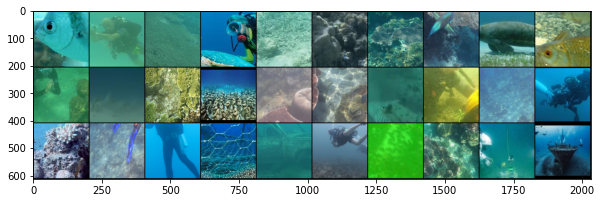

Ground truth images.


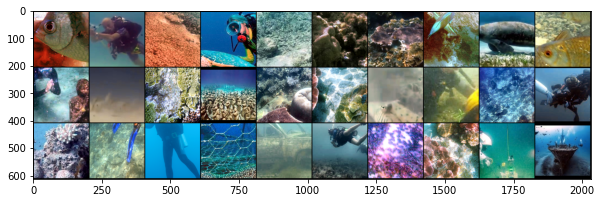

Model outputs.


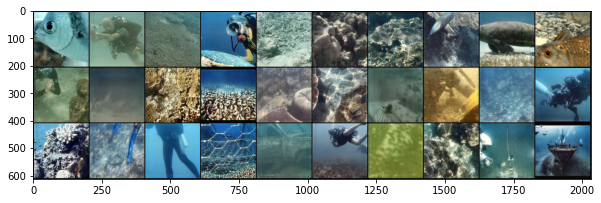

In [12]:
# test_dir = 'challenging-60-super'

# test_dataset = datasets.ImageFolder('challenging-60-super/', transform=transform)
# test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False) 

RE_Expose = RE_Expose_Net()
state_dict = torch.load('ReExpose/ReExpose.pth')
RE_Expose.load_state_dict(state_dict)
RE_Expose.eval()

RE_Expose.cuda()

def imshow(img):
    # unnormalize
    img = img.clamp(0, 1)
    npimg = img.numpy()
    fig = plt.figure(figsize=(10,10))
    ax  = fig.add_subplot(111)
    ax.imshow(np.transpose(npimg, (1, 2, 0)))
    #ax.set_title('CNN VAE (80 Epochs)')
    plt.show()
    #fig.savefig('example.png', dpi = 300)
    
# get some random training images
dataiter = iter(valloader)
images, labels = dataiter.next()

print("Original images.")
imshow(torchvision.utils.make_grid(images[:30], 10, 3))

print("Ground truth images.")
imshow(torchvision.utils.make_grid(labels[:30], 10, 3))

print("Model outputs.")
with torch.no_grad():
    images      = images.cuda()
    outs        = RE_Expose(images)
    outs        = outs.cpu()
    outs        = torch.reshape(outs, images.shape)
    imshow(torchvision.utils.make_grid(outs[:30], 10, 3))

In [13]:
test_dir = 'challenging-60'

testtransform = transforms.Compose([
    transforms.ToTensor(),
])

model = RE_Expose_Net()
state_dict = torch.load('ReExpose/ReExpose.pth')
model.load_state_dict(state_dict)
model.eval()

model.cuda()

def pil_loader(path):
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, 'rb') as f:
        with Image.open(f) as img:
            return img.convert('RGB')

for f in tqdm(os.listdir(test_dir)):
    if 'png' in f:
        data = testtransform(pil_loader(test_dir + '/' + f))
        data = data.view(1, data.size(0), data.size(1), data.size(2))
        data = data.cuda()

        output = model(data)
        output = output.squeeze(0)
        output = output.permute(1, 2, 0)
        
        im = output.cpu().detach().numpy()
        
        #plt.imshow(pil_loader(test_dir + '/' + f))
        #plt.show() 

        imsave('ReExpose/Results/' + f, im)

        #plt.imshow(im)
        #plt.show()   

100%|██████████| 60/60 [02:11<00:00,  2.19s/it]
